### Topic Modeling - Legal Text

Ref: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

### LDA Implementation

1. Loading data
2. Data cleaning
3. Exploratory analysis
4. Preparing data for LDA analysis
5. Model Evaluation and parameter tuning

In [11]:
import pandas as pd
import os

case = pd.read_csv('../legal_text_classification.csv', encoding='utf-8')
case = case.dropna(subset=['case_text'])
case.head()

,case_id,case_outcome,case_title,case_text
0,Case1,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,Case2,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,Case3,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,Case4,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,Case5,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...


#### Data Cleaning

In [12]:
case = case.drop(columns=['case_id'], axis=1)
case.head()

,case_outcome,case_title,case_text
0,cited,Alpine Hardwood (Aust) Pty Ltd v Hardys Pty Lt...,Ordinarily that discretion will be exercised s...
1,cited,Black v Lipovac [1998] FCA 699 ; (1998) 217 AL...,The general principles governing the exercise ...
2,cited,Colgate Palmolive Co v Cussons Pty Ltd (1993) ...,Ordinarily that discretion will be exercised s...
3,cited,Dais Studio Pty Ltd v Bullett Creative Pty Ltd...,The general principles governing the exercise ...
4,cited,Dr Martens Australia Pty Ltd v Figgins Holding...,The preceding general principles inform the ex...


#### Remove punctuation/lower casing

In [13]:
import re
import pandas as pd
import nltk
from gensim.parsing.preprocessing import preprocess_string

# clean, tokenize, and stem the text data
def preprocess_text(text):
    # remove email addresses
    text = re.sub(r'\S*@\S*\s?', '', text)
    # remove any non-alphanumeric characters and convert to lowercase
    text = re.sub('[,\.!?]', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\'", "", text)
    text = text.lower()

    # preprocess the text using gensim's preprocessing functions
    processed_text = preprocess_string(text)
    processed_text_str = ' '.join(processed_text)
    
    return processed_text_str

# apply the clean_text function to the column of text data in the DataFrame
case['case_text_processed'] = case['case_text'].apply(preprocess_text)

# Print out the first rows of case
case['case_text_processed'].head()

0    ordinarili discret exercis cost follow event a...
1    gener principl govern exercis discret award in...
2    ordinarili discret exercis cost follow event a...
3    gener principl govern exercis discret award in...
4    preced gener principl inform exercis discret d...
Name: case_text_processed, dtype: object

#### Exploratory Analysis

Use word cloud to verify if preprocessing happened correctly

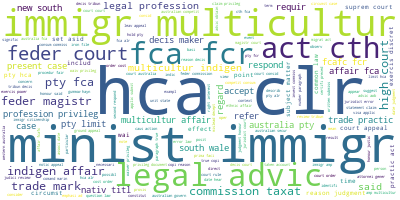

In [14]:
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = ','.join(list(case['case_text_processed'].values))

wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')
wordcloud.generate(long_string)
wordcloud.to_image()

#### Prepare text for LDA analysis

- Transform textual data in a format to be an input for training LDA model
- Convert documents into a simple vector representation (Bag of Words BOW)
- Convert list of titles into lists of vectors, all with length equal to the vocabulary
- Plot ten most frequent words based on the outcome

c:\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


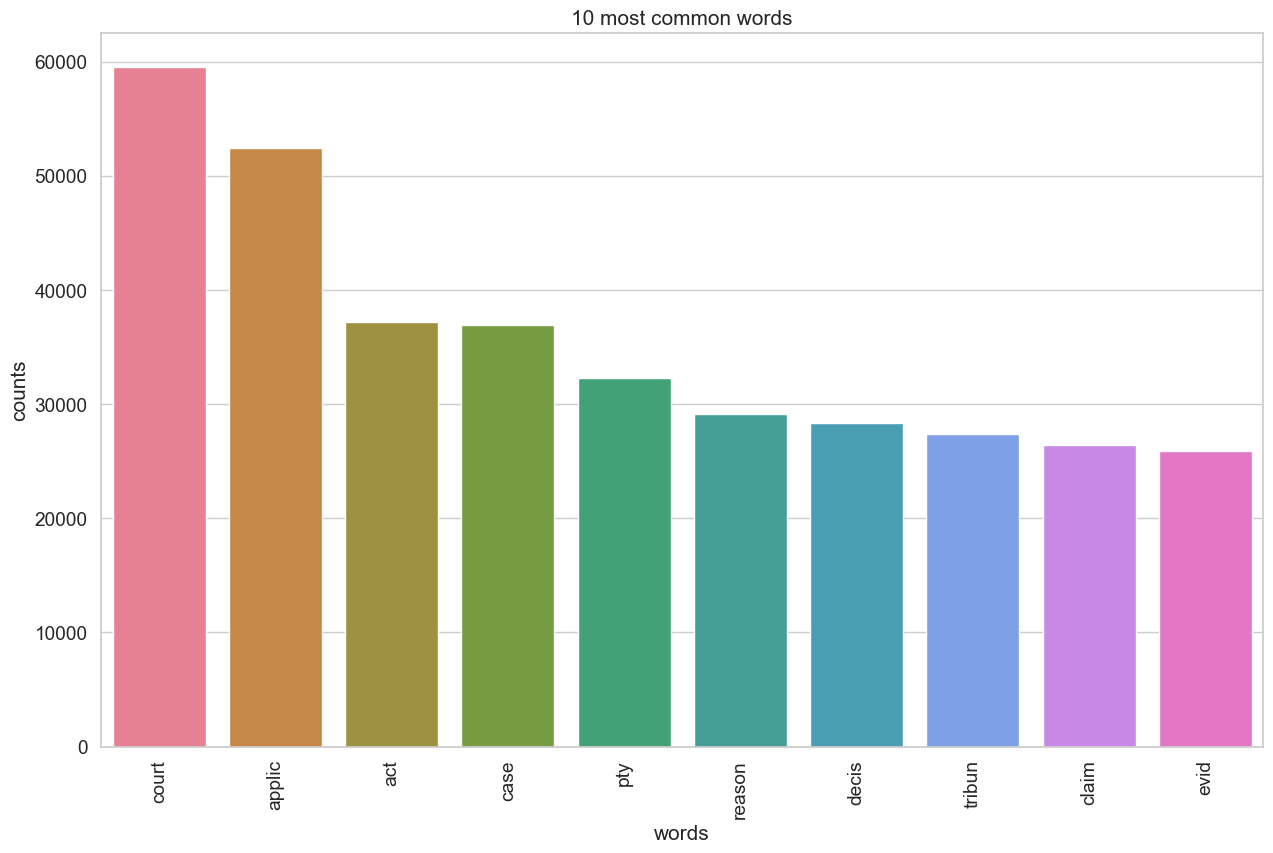

In [15]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names_out()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(case['case_text_processed'])

# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [16]:
# save count vectorizer to file
with open('count_vectorizer.pkl', 'wb') as f:
    pickle.dump(count_vectorizer, f)

### Train LDA model

Tweak the number of topic parameters (make things simple)

In [17]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below (use int values below 15)
number_topics = 3 # after several iterations, dataset has 3 distinct topics
number_words = 14

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
tribun applic decis court minist reason appel act case immigr hca affair law evid

Topic #1:
document privileg legal awb advic evid disclosur claim purpos waiver case profession disclos relat

Topic #2:
court pty applic act order case parti proceed respond fca claim australia cost reason


### Analyze LDA model

Visualize topics for interpretability

Use pyLDAvis to:
1. Better understanding and interpreting individual topics
<br>&nbsp;&nbsp;&nbsp;&nbsp;- Manually select each topic to view its top most frequent and/or “relevant” terms, using different values of the λ 
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; parameter
<br>&nbsp;&nbsp;&nbsp;&nbsp;- Helps when you try assign a human interpretable name/"meaning" to each topic
2. Better understanding the relationships between the topics.
<br>&nbsp;&nbsp;&nbsp;&nbsp;- Explore Intertopic Distance Plot to learn how topics relate to each other, including potential higher-level structure
<br>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; between groups of topics

In [18]:
%%time
import pickle 
import pyLDAvis
import pyLDAvis.sklearn

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+ str(number_topics))

if not os.path.exists(LDAvis_data_filepath):
    LDAvis_prepared = pyLDAvis.sklearn.prepare(lda, count_data, count_vectorizer)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
else:
    # load the pre-prepared pyLDAvis data from disk
    with open(LDAvis_data_filepath, 'rb') as f:
        LDAvis_prepared = pickle.load(f, encoding='utf-8')

pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

LDAvis_prepared

Wall time: 551 ms


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.060727  0.084234       1        1  40.046775
2     -0.071316 -0.079848       2        1  36.382087
1      0.132043 -0.004386       3        1  23.571138, topic_info=           Term          Freq         Total Category  logprob  loglift
6965   document  20113.000000  20113.000000  Default  30.0000  30.0000
25805    tribun  27249.000000  27249.000000  Default  29.0000  29.0000
19740  privileg  16269.000000  16269.000000  Default  28.0000  28.0000
1806        awb  12976.000000  12976.000000  Default  27.0000  27.0000
14106     legal  16737.000000  16737.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
12546      issu   4991.283596  16427.506895   Topic3  -5.3992   0.2539
20047    purpos   4694.831640  15403.442013   Topic3  -5.4604   0.2570
20499    reason   4434.655527  28945.372760   Topic3  -5.5175  -0.4308
20963   respect   4038.304578  11524.940189   Topic3  -5.6111   0.3965
15397    matter   4046.847754  19350.774534   Topic3  -5.6090  -0.1196

[278 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
194        1  0.997052     aclc
194        2  0.001679     aclc
225        1  0.938466     acsr
225        2  0.009901     acsr
225        3  0.051587     acsr
...      ...       ...      ...
28134      1  0.213523     word
28134      2  0.743718     word
28134      3  0.042790     word
28137      2  0.996914   worimi
28327      3  0.998945  wrongdo

[476 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2])

In [19]:
import pickle

with open('topic_model.pkl', 'wb') as f:
    pickle.dump(lda, f)